## Libraries

In [3]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd




# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns



# Preprocesamiento
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder 
import math
from sklearn.preprocessing import MinMaxScaler
from scipy import stats


# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer


#Linear Regresion con Sklearn
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics




# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


# Tamaño gráficas
# ==============================================================================
plt.rcParams["figure.figsize"] = (10,8)

In [4]:
df = pd.read_csv('../data/test.csv')
df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.32,Ideal,I,SI1,60.5,58.0,4.43,4.49,2.70
1,1,1.24,Premium,I,SI1,62.9,60.0,6.80,6.74,4.26
2,2,1.66,Premium,D,SI1,62.0,59.0,7.55,7.60,4.70
3,3,0.75,Premium,D,SI2,60.6,56.0,5.94,5.90,3.59
4,4,1.50,Fair,E,SI2,64.8,55.0,7.26,7.15,4.67


## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13485 entries, 0 to 13484
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       13485 non-null  int64  
 1   carat    13485 non-null  float64
 2   cut      13485 non-null  object 
 3   color    13485 non-null  object 
 4   clarity  13485 non-null  object 
 5   depth    13485 non-null  float64
 6   table    13485 non-null  float64
 7   x        13485 non-null  float64
 8   y        13485 non-null  float64
 9   z        13485 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.0+ MB


In [6]:
df.isnull().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

0

In [10]:
df.isnull().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
dtype: int64

In [11]:
df.select_dtypes(include = np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
id,13485.0,6742.000000,3892.928525,0.0,3371.00,6742.00,10113.00,13484.00
carat,13485.0,0.799032,0.468195,0.2,0.40,0.71,1.04,4.13
depth,13485.0,61.758487,1.420037,50.8,61.10,61.90,62.50,79.00
table,13485.0,57.473652,2.234259,43.0,56.00,57.00,59.00,73.00
x,13485.0,5.737139,1.111265,0.0,4.73,5.71,6.54,10.14
y,13485.0,5.739416,1.103297,0.0,4.74,5.72,6.54,10.10
z,13485.0,3.542883,0.689553,0.0,2.92,3.53,4.04,6.43


## Visualization

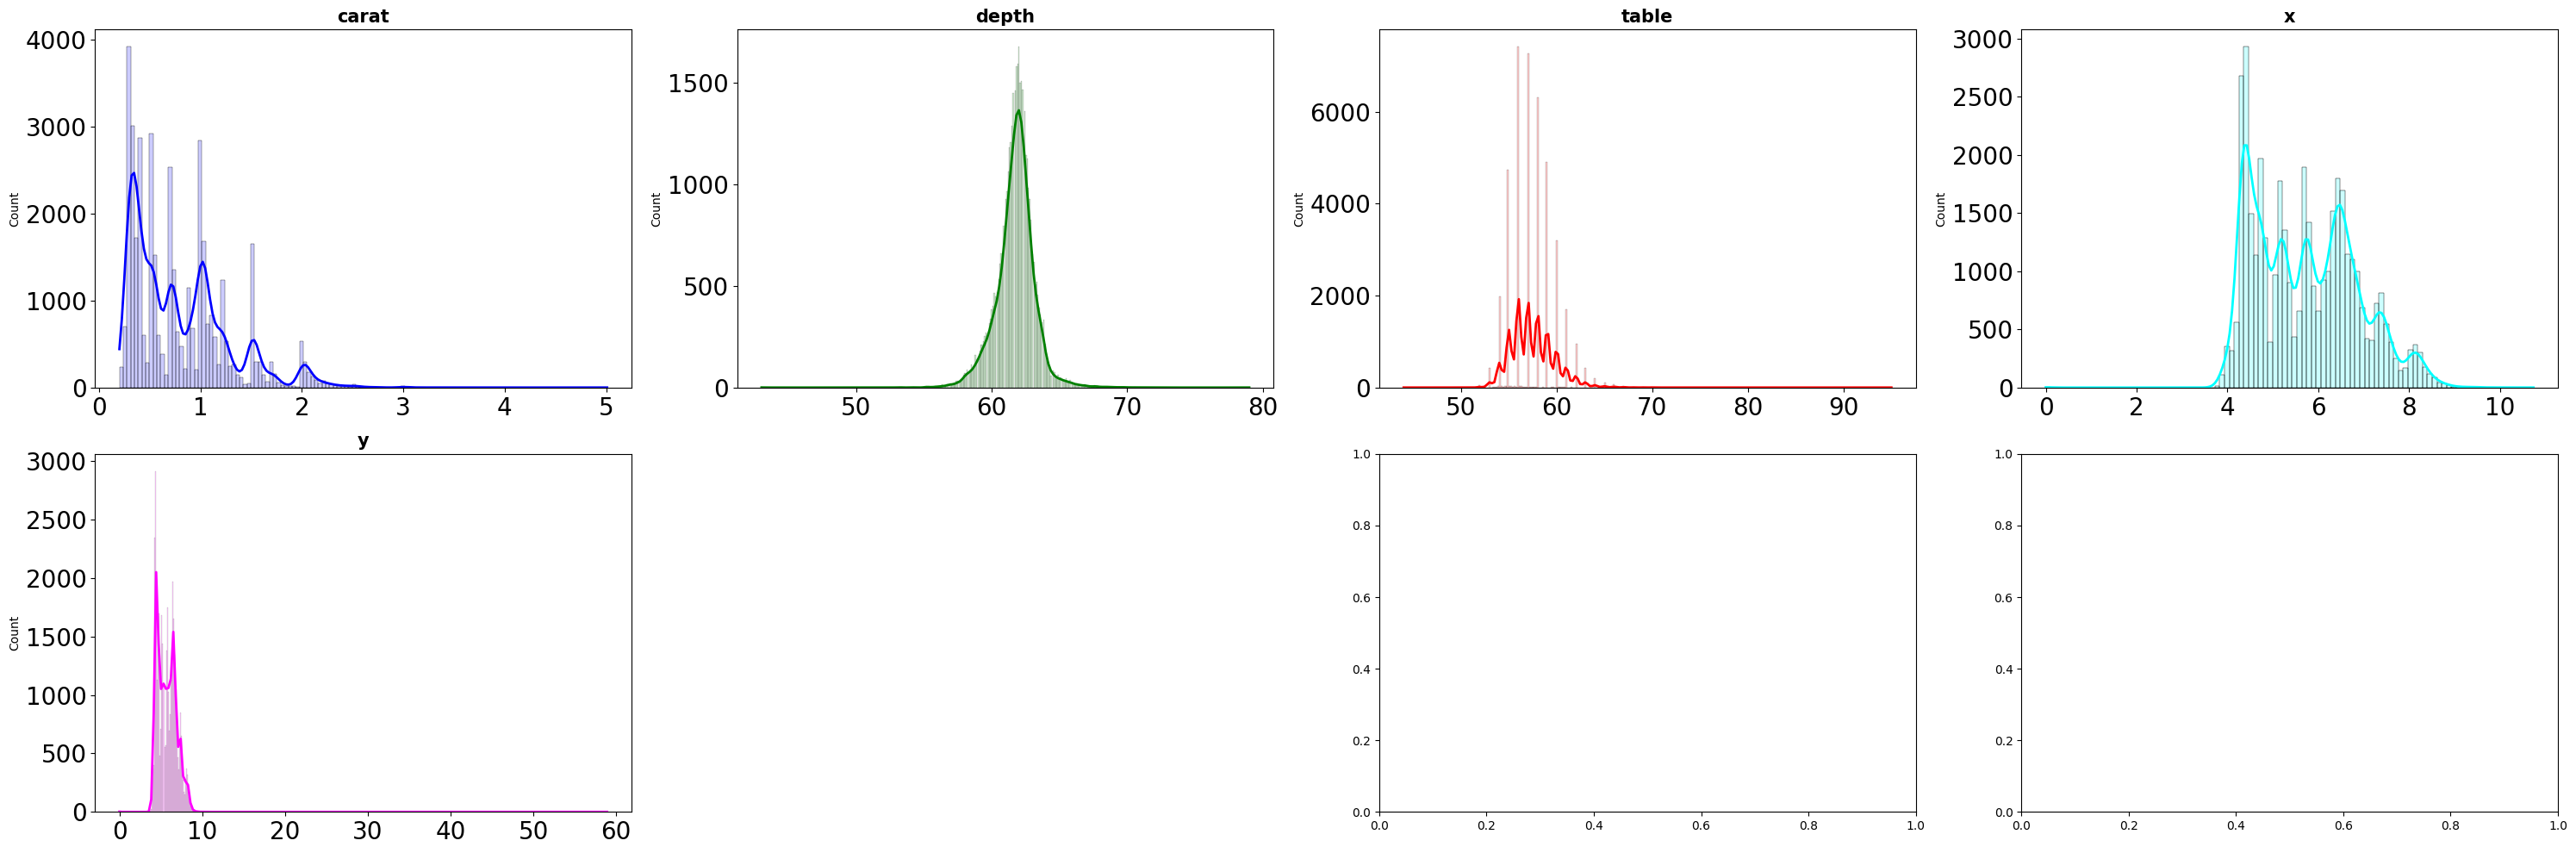

In [ ]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (30, 10))

lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange"]

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop(["price","id"])

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df,
        x = colum,
        kde = True, 
        color = lista_colores[i], 
        line_kws = {"linewidth": 2}, 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    

fig.tight_layout()
fig.delaxes(axes[i]) # Eliminamos el último eje que no se usa;

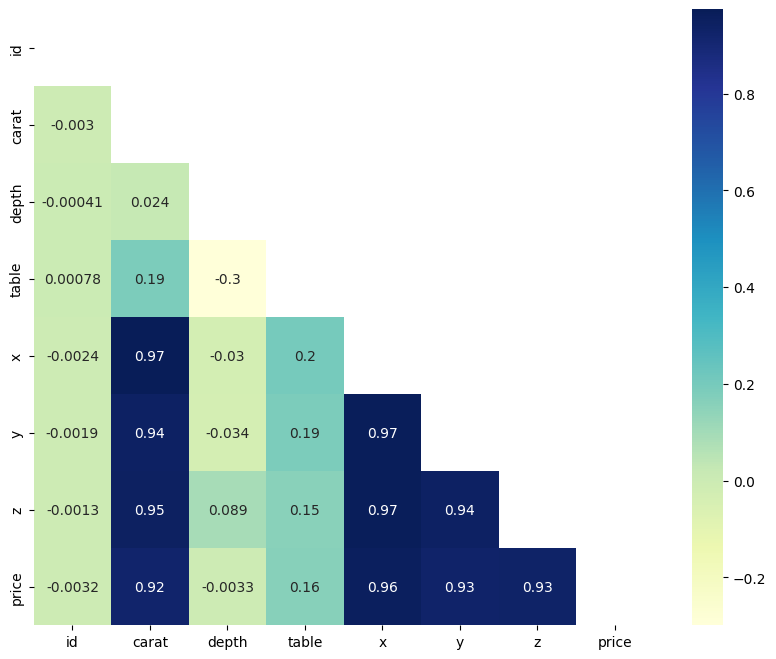

In [ ]:
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype = np.bool_))

sns.heatmap(df.corr(numeric_only = True), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

## Null Management

### There are no nulls in the df

## Outlier management

In [13]:
df_numericas = df.select_dtypes(include=np.number)
df_numericas.head(2)

,id,carat,depth,table,x,y,z
0,0,0.32,60.5,58.0,4.43,4.49,2.70
1,1,1.24,62.9,60.0,6.80,6.74,4.26


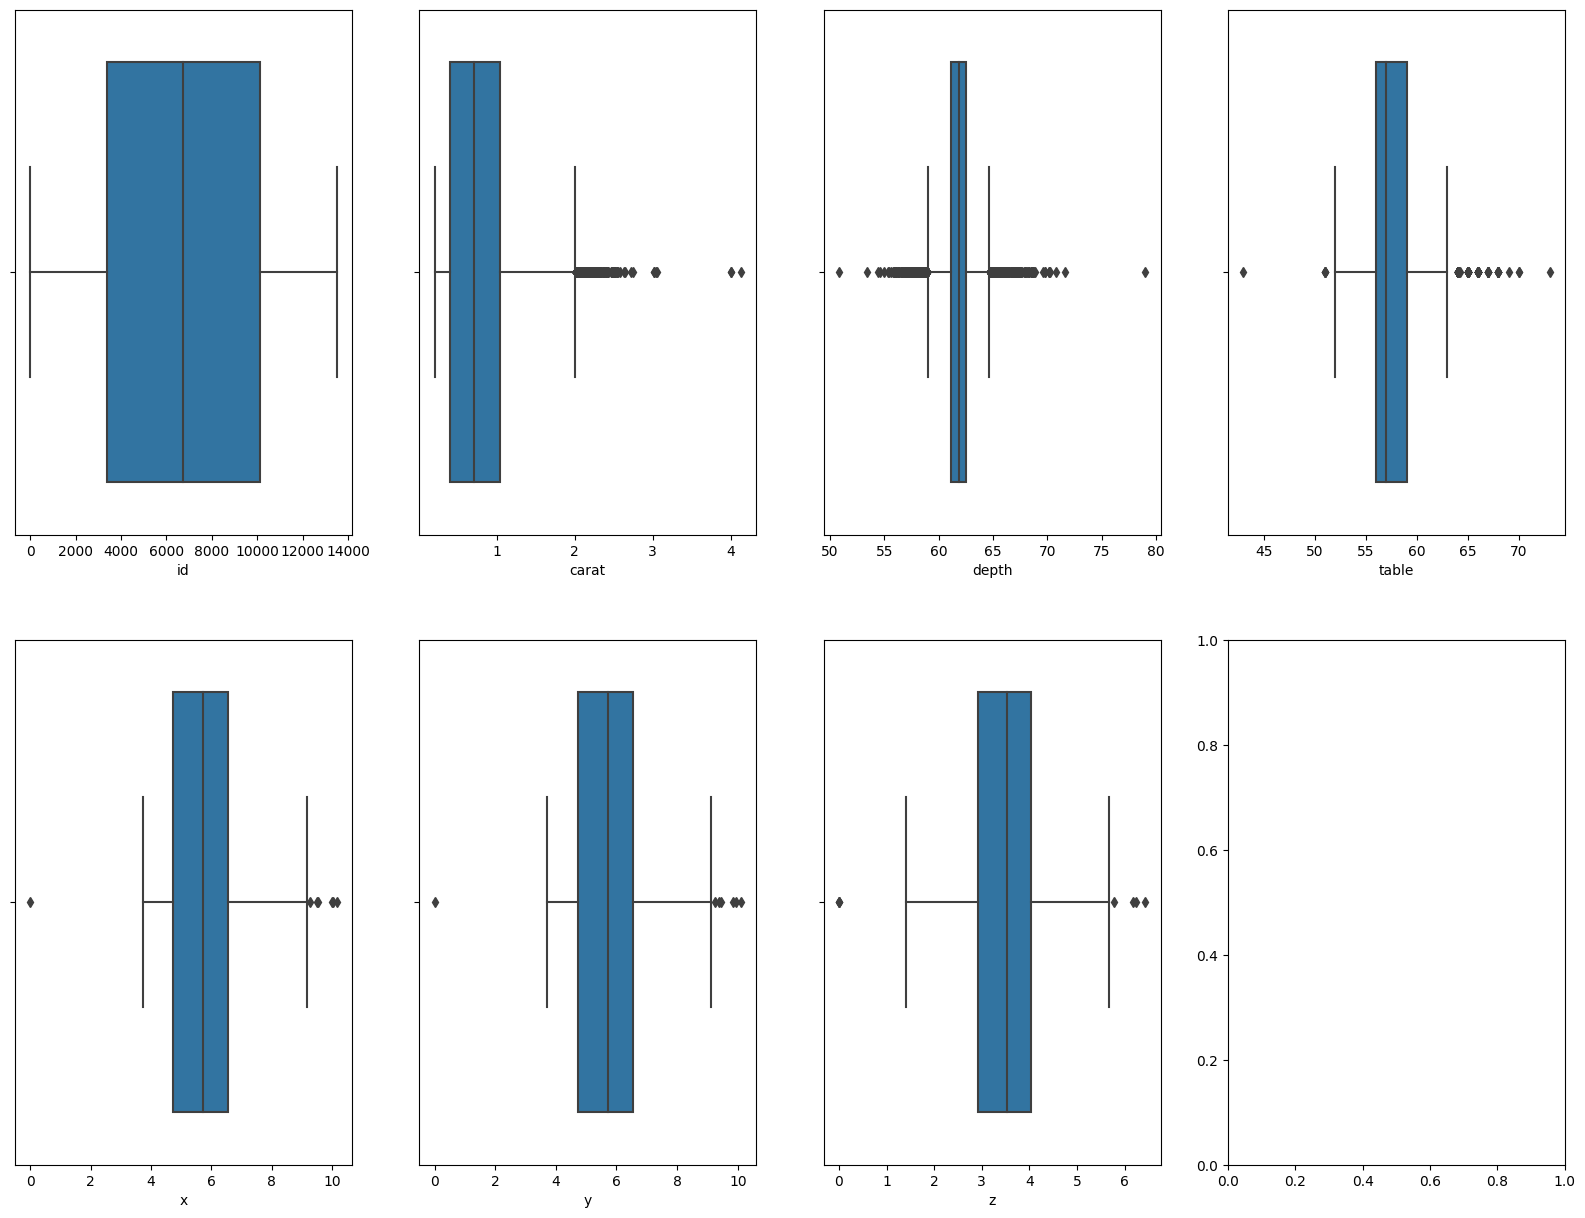

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(20,15))
axes = axes.flat

for indice, columna in enumerate(df_numericas.columns):
    sns.boxplot(x=columna, data=df_numericas, ax=axes[indice])
plt.show()

In [15]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(dataframe[col], 25)
        Q3 = np.nanpercentile(dataframe[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices 

In [16]:
lista_columnas = df_numericas.columns
lista_columnas

Index(['id', 'carat', 'depth', 'table', 'x', 'y', 'z'], dtype='object')

In [17]:
# aplicamos la función y sacamos los índices de los outliers.

ind = detectar_outliers(lista_columnas, df)
print(ind)

{'carat': [22, 27, 34, 39, 47, 112, 146, 194, 229, 239, 292, 307, 317, 354, 357, 360, 366, 384, 401, 403, 501, 511, 539, 608, 614, 705, 758, 763, 767, 769, 784, 796, 935, 976, 1025, 1033, 1046, 1128, 1150, 1237, 1267, 1285, 1353, 1373, 1385, 1398, 1439, 1481, 1507, 1549, 1569, 1573, 1588, 1591, 1684, 1689, 1708, 1753, 1778, 1795, 1796, 1804, 1844, 1851, 1900, 1905, 1907, 1954, 2051, 2063, 2077, 2115, 2160, 2288, 2297, 2341, 2354, 2366, 2396, 2461, 2463, 2465, 2474, 2567, 2615, 2642, 2656, 2662, 2755, 2901, 2913, 2915, 2932, 2955, 2970, 3088, 3112, 3122, 3141, 3170, 3219, 3236, 3251, 3275, 3297, 3353, 3362, 3425, 3428, 3443, 3454, 3458, 3555, 3564, 3565, 3631, 3658, 3677, 3767, 3834, 3920, 3935, 3985, 3989, 4007, 4014, 4084, 4120, 4156, 4188, 4189, 4229, 4232, 4259, 4285, 4313, 4345, 4369, 4476, 4496, 4525, 4526, 4531, 4542, 4594, 4610, 4612, 4640, 4656, 4669, 4678, 4689, 4740, 4747, 4800, 4810, 4897, 5011, 5076, 5102, 5135, 5179, 5216, 5249, 5302, 5327, 5361, 5433, 5454, 5458, 5519, 55

## Encoding

In [18]:
df.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,0,0.32,Ideal,I,SI1,60.5,58.0,4.43,4.49,2.70
1,1,1.24,Premium,I,SI1,62.9,60.0,6.80,6.74,4.26
2,2,1.66,Premium,D,SI1,62.0,59.0,7.55,7.60,4.70
3,3,0.75,Premium,D,SI2,60.6,56.0,5.94,5.90,3.59
4,4,1.50,Fair,E,SI2,64.8,55.0,7.26,7.15,4.67


In [20]:
#Fair, Good, Very Good, Premium, Ideal
df.cut.unique()


array(['Ideal', 'Premium', 'Fair', 'Good', 'Very Good'], dtype=object)

In [21]:
map_ = {"Fair" : 0,
        "Good" : 1,
        "Very Good" : 2,
        "Premium" : 3,
        "Ideal" : 4}

In [22]:
df["cut_map"] = df["cut"].map(map_)
df.drop(['cut'], axis=1, inplace= True)


In [23]:
df

,id,carat,color,clarity,depth,table,x,y,z,cut_map
0,0,0.32,I,SI1,60.5,58.0,4.43,4.49,2.70,4
1,1,1.24,I,SI1,62.9,60.0,6.80,6.74,4.26,3
2,2,1.66,D,SI1,62.0,59.0,7.55,7.60,4.70,3
3,3,0.75,D,SI2,60.6,56.0,5.94,5.90,3.59,3
4,4,1.50,E,SI2,64.8,55.0,7.26,7.15,4.67,0
...,...,...,...,...,...,...,...,...,...,...
13480,13480,1.10,G,SI1,59.6,60.0,6.74,6.70,4.00,3
13481,13481,0.90,D,SI1,62.1,60.0,6.14,6.20,3.83,2
13482,13482,0.30,F,VS2,62.1,53.3,4.30,4.32,2.68,4
13483,13483,1.25,I,SI1,59.6,59.0,7.01,7.09,4.20,4


In [24]:
# vamos a definir una función que nos aplique este método

def one_hot_encoder(dff, columnas):
    
    '''
    columnas: lista
    '''
    
    oh = OneHotEncoder()
    
    transformados = oh.fit_transform(dff[columnas])
    
    oh_df = pd.DataFrame(transformados.toarray(), columns = oh.get_feature_names_out(), dtype = int)
    
    dff[oh_df.columns] = oh_df
    
    dff.drop(columnas, axis = 1, inplace = True)
    
    return dff

In [25]:
df = one_hot_encoder(df, ["color", "clarity"])
df.head()

,id,carat,depth,table,x,y,z,cut_map,color_D,color_E,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0,0.32,60.5,58.0,4.43,4.49,2.70,4,0,0,...,1,0,0,0,1,0,0,0,0,0
1,1,1.24,62.9,60.0,6.80,6.74,4.26,3,0,0,...,1,0,0,0,1,0,0,0,0,0
2,2,1.66,62.0,59.0,7.55,7.60,4.70,3,1,0,...,0,0,0,0,1,0,0,0,0,0
3,3,0.75,60.6,56.0,5.94,5.90,3.59,3,1,0,...,0,0,0,0,0,1,0,0,0,0
4,4,1.50,64.8,55.0,7.26,7.15,4.67,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13485 entries, 0 to 13484
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            13485 non-null  int64  
 1   carat         13485 non-null  float64
 2   depth         13485 non-null  float64
 3   table         13485 non-null  float64
 4   x             13485 non-null  float64
 5   y             13485 non-null  float64
 6   z             13485 non-null  float64
 7   cut_map       13485 non-null  int64  
 8   color_D       13485 non-null  int32  
 9   color_E       13485 non-null  int32  
 10  color_F       13485 non-null  int32  
 11  color_G       13485 non-null  int32  
 12  color_H       13485 non-null  int32  
 13  color_I       13485 non-null  int32  
 14  color_J       13485 non-null  int32  
 15  clarity_I1    13485 non-null  int32  
 16  clarity_IF    13485 non-null  int32  
 17  clarity_SI1   13485 non-null  int32  
 18  clarity_SI2   13485 non-nu

In [27]:
df.isnull().sum()

id              0
carat           0
depth           0
table           0
x               0
y               0
z               0
cut_map         0
color_D         0
color_E         0
color_F         0
color_G         0
color_H         0
color_I         0
color_J         0
clarity_I1      0
clarity_IF      0
clarity_SI1     0
clarity_SI2     0
clarity_VS1     0
clarity_VS2     0
clarity_VVS1    0
clarity_VVS2    0
dtype: int64

## Standardization And Normalization


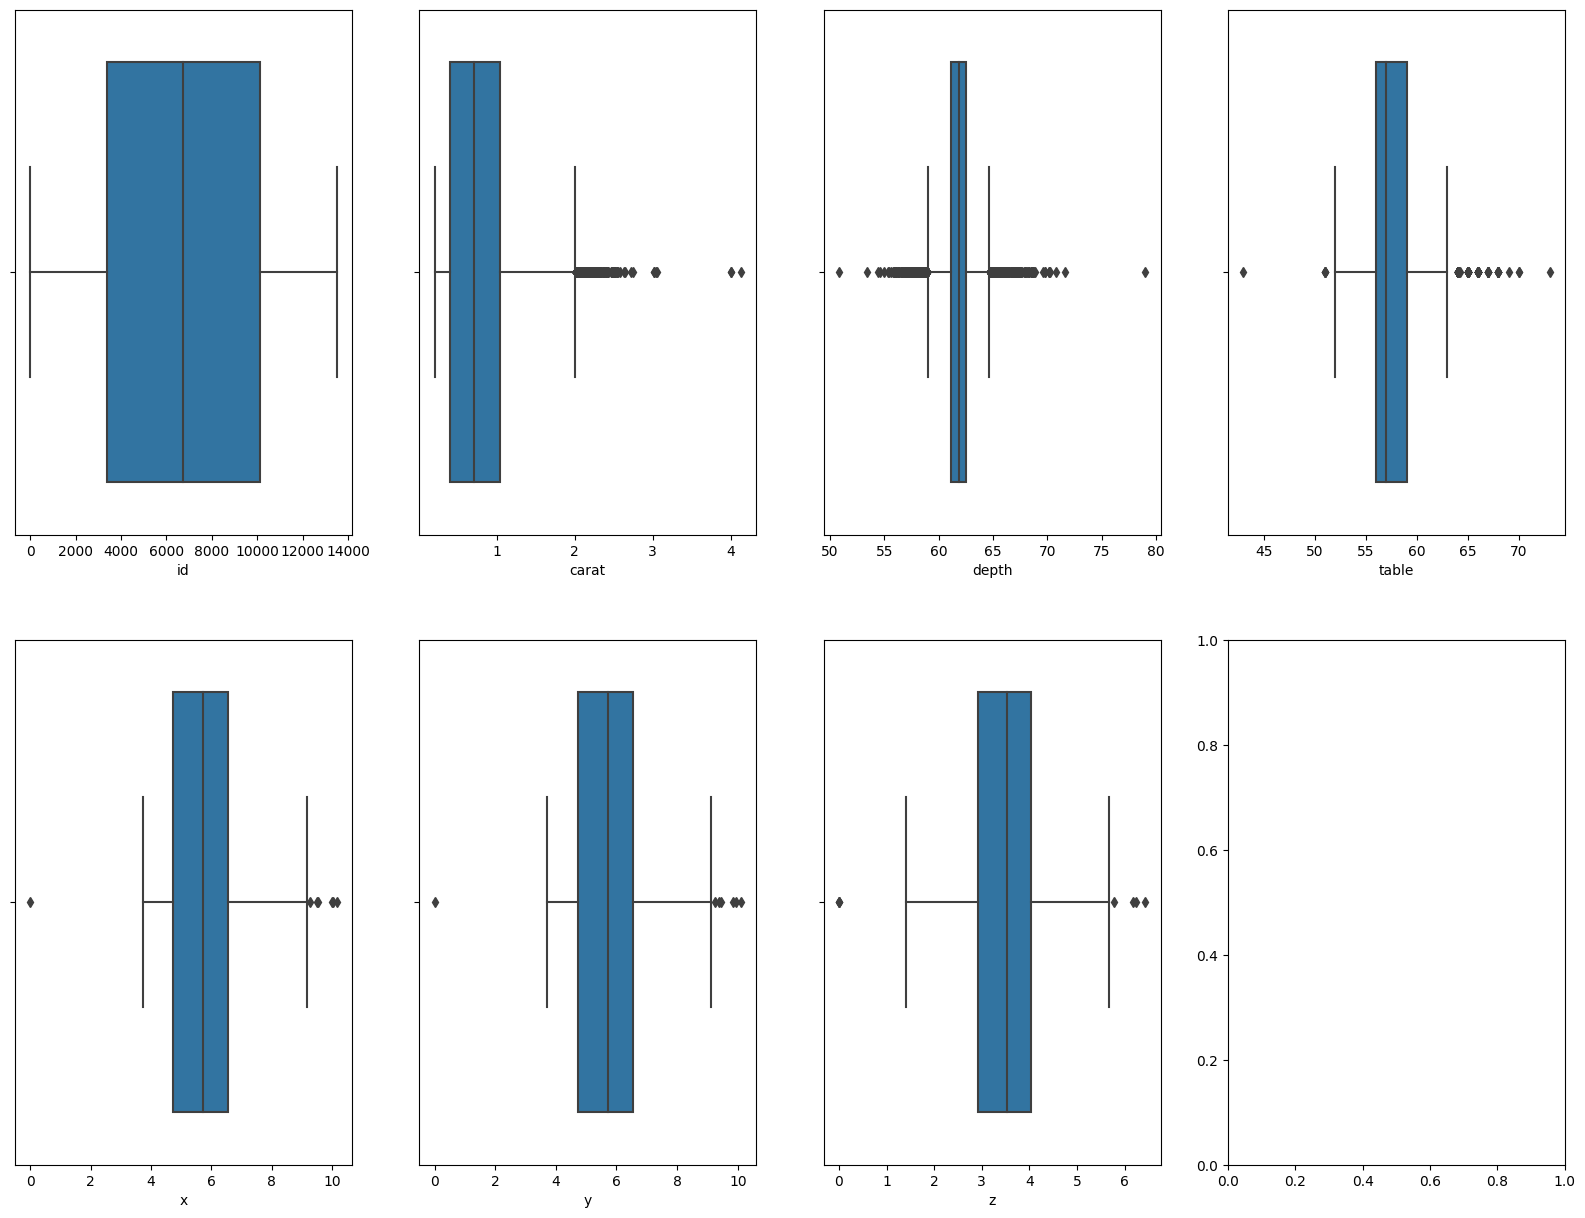

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(20,15))
axes = axes.flat

for indice, columna in enumerate(df_numericas.columns):
    sns.boxplot(x=columna, data=df_numericas, ax=axes[indice])
plt.show()

In [30]:
# creamos una lista con todas las variables numericas predictoras, eliminamos la variable respuesta porque esa esta normalizada
num_col = ['carat', 'depth', 'table', 'x', 'y', 'z']

In [31]:
# iniciamos la clase para escalar
scaler_robust = RobustScaler()

# ajustamos nuestros datos
X_escaladas_robust = scaler_robust.fit_transform(df[num_col])

# hacemos una copia del dataframe para insertar las columnas estandarizadas
df_robust = df.copy()


# insertamos los valores estandarizados en el DataFrame
df_robust[num_col] = X_escaladas_robust
df_robust.head()

,id,carat,depth,table,x,y,z,cut_map,color_D,color_E,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0,-0.609375,-1.000000,0.333333,-0.707182,-0.683333,-0.741071,4,0,0,...,1,0,0,0,1,0,0,0,0,0
1,1,0.828125,0.714286,1.000000,0.602210,0.566667,0.651786,3,0,0,...,1,0,0,0,1,0,0,0,0,0
2,2,1.484375,0.071429,0.666667,1.016575,1.044444,1.044643,3,1,0,...,0,0,0,0,1,0,0,0,0,0
3,3,0.062500,-0.928571,-0.333333,0.127072,0.100000,0.053571,3,1,0,...,0,0,0,0,0,1,0,0,0,0
4,4,1.234375,2.071429,-0.666667,0.856354,0.794444,1.017857,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [32]:
df_robust.to_csv("../data/one_test.csv")